# <center> An Unsupervised Approach For Identifying Patient Trial Eligibility </center>
### <center> Meet Gandhi, Department of Computer and Information Science </center>
### <center> University of Pennsylvania </center>

# Imports

In [ ]:
import os
import re
import nltk
import spacy
import torch
import scispacy
import itertools
import numpy as np
import pandas as pd
from spacy import displacy
import matplotlib.pyplot as plt
from thefuzz import fuzz, process
from sklearn.decomposition import TruncatedSVD
from scispacy.umls_linking import UmlsEntityLinker
from sentence_transformers import SentenceTransformer
from scispacy.abbreviation import AbbreviationDetector
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from semantic_text_similarity.models import ClinicalBertSimilarity

from tqdm.auto import tqdm
tqdm.pandas()

nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/mgandhi5/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Loading Data

In [ ]:
BASE_PATH = "."

In [ ]:
# Reading the collated patient notes data from the MIMIC-III database
df_pats = pd.read_parquet(f"{BASE_PATH}/latest_mimic_notes.parquet")
df_pats.head()

,SUBJECT_ID,HADM_ID,DIAGNOSIS,GENDER,AGE,CATEGORY,TEXT
31,17960,147194,PREMATURITY,M,1,Nursing/other,Nursing Note 1120 Mother here to take infant C...
35,4551,162529,NEWBORN,F,0,Nursing/other,Nursing Admit Note Baby Girl [**Known lastname...
47,25501,191310,NEWBORN,M,0,Nursing/other,[**Location (un) 227**]/[**Hospital **] TRANSF...
76,17930,168325,NEWBORN,M,0,Nursing/other,Admission Note Baby [**Name (NI) 77**] [**Kn...
113,3144,179849,NEWBORN,M,0,Nursing/other,NPN 1900-0700 1. SEPSIS O: Receiving ampi/ge...


Below, we select an actively recruiting Pneumonia trial (NCT id: NCT03482245)



In [ ]:
# NCT03482245 
inc = """
Patients undergoing appendectomy for appendicitis\n
Patients undergoing colon resection for diverticulitis\n
Patients undergoing treatment of pneumonia\n
"""

exc = """
traumatic brain injury, blindness, immunocompromised or immunosuppressed state
"""

trial_params = {
    'min_age': 18,
    'max_age': 99,
    'gender': 'A', # M -> Male, F -> Female, A -> All
    'condition': 'Pneumonia|Appendicitis|Diverticulitis',
    'inclusion': inc,
    'exclusion': exc,
}

# Functions & Classes

## Scoring Functions

In [ ]:
class UMLSSimilarity:
    """
    A class that provides semantic similarity scores between text queries and documents
    based on Unified Medical Language System (UMLS) concepts.
    Attributes:
    -----------
    nlp: spacy Language object
        A spaCy pipeline object for parsing text and extracting named entities.
    linker: UmlsEntityLinker object
        An object for linking named entities to UMLS concepts.

    Methods:
    --------
    get_concepts(text: str) -> List[str]:
        Extracts UMLS concepts from text and returns a list of their canonical names.
    score(query_lst: List[str], text_lst: List[str]) -> float:
        Calculates a semantic similarity score between a list of text queries and a list of
        documents using their UMLS concepts.
    """

    def __init__(self):
        """
        Initializes the UMLSSimilarity object by loading the 'en_core_sci_lg' spaCy pipeline
        and adding the abbreviation and entity linking pipes to it.
        """
        self.nlp = spacy.load("en_core_sci_lg")
        # Add the abbreviation pipe to the spacy pipeline.
        self.nlp.add_pipe("abbreviation_detector")
        # Add the entity linking pipe to the spacy pipeline
        self.nlp.add_pipe("scispacy_linker")
        self.linker = UmlsEntityLinker(resolve_abbreviations=True, name='linker')
        
    def get_concepts(self, text):
        """
        Extracts UMLS concepts from text and returns a list of concepts.

        Parameters:
        -----------
        text: str
            The text to extract concepts from.

        Returns:
        --------
        List[str]:
            A list of extracted UMLS concepts from the text.
        """
        doc = self.nlp(text)
        concept_lst = []
        for ent in doc.ents:
            umls_cuis = ent._.umls_ents
            if len(umls_cuis):
                highest_umls_cui_score = umls_cuis[0][1]
                if highest_umls_cui_score > 0.9:
                    highest_umls_cui = umls_cuis[0][0]
                    umls_concept_name = self.linker.umls.cui_to_entity[
                        highest_umls_cui
                    ].canonical_name
                    concept_lst.append(umls_concept_name)
        return concept_lst

    def score(self, query_lst, text_lst):
        """
        Calculates intersection over union score between a list of text queries and a list of
        documents using their UMLS concepts.

        Parameters:
        -----------
        query_lst: List[str]
            A list of text queries to compare to the documents.
        text_lst: List[str]
            A list of documents to compare to the queries.

        Returns:
        --------
        float:
            A similarity score between the query and the document based on their UMLS concepts.
        """
        query_concepts = set()
        for query in query_lst:
            query_concepts = query_concepts.union(
                set(self.get_concepts(query))
            )
        text_concepts = set()
        for text in text_lst:
            text_concepts = text_concepts.union(
                set(self.get_concepts(text))
            )
        inter = query_concepts.intersection(text_concepts)
        if len(inter) == 0:
            out = 0
        else:
            out = len(inter)/len(query_concepts)
        return round(out * 100)


class TFIDFSimilarity:
    """
    A class for computing the similarity score between a query and a text using TF-IDF.

    Args:
    - tfidf_obj: sklearn.feature_extraction.text.TfidfVectorizer
        A fitted TfidfVectorizer object.
    - pca_obj: sklearn.decomposition.TruncatedSVD or None
        A fitted PCA object. If None, PCA is not applied.

    Methods:
    - from_corpus(cls, corpus, tfidf_conf, sent_tokenize=True, pca=None)
        Returns a TFIDFSimilarity object fitted on the given corpus using the specified 
        TfidfVectorizer configuration and, if specified, PCA.
    - from_pretrained(cls, path)
        Returns a TFIDFSimilarity object loaded from the specified path containing 
        the saved TfidfVectorizer and PCA objects.
    - save(self, path)
        Saves the fitted TfidfVectorizer and PCA objects to the specified path.
    - score(self, query_lst, text_lst, visualize=False)
        Computes the similarity score between a query and a text using TF-IDF.
        If visualize is True, returns a space compatible visualization dictionary.
    """
    def __init__(self, tfidf_obj, pca_obj):
        """
        Initializes the TFIDFSimilarity object.

        Args:
        - tfidf_obj: sklearn.feature_extraction.text.TfidfVectorizer
            A fitted TfidfVectorizer object.
        - pca_obj: sklearn.decomposition.TruncatedSVD or None
            A fitted PCA object. If None, PCA is not applied.
        """
        self.tfidf = tfidf_obj
        print(f"Vocabulary has {self.tfidf.idf_.shape[0]} words")
        self.pca = pca_obj
        if pca_obj:
            print(f"PCA has {self.pca.explained_variance_ratio_.shape[0]} components")

    @classmethod
    def from_corpus(cls, corpus, tfidf_conf, sent_tokenize=True, pca=None):
        """
        Returns a TFIDFSimilarity object fitted on the given corpus using the specified 
        TfidfVectorizer configuration and, if specified, PCA.

        Args:
        - corpus: list
            A list of documents to fit the TfidfVectorizer and PCA objects.
        - tfidf_conf: dict
            A dictionary containing TfidfVectorizer configuration parameters.
        - sent_tokenize: bool, default=True
            Whether to sentence tokenize the corpus.
        - pca: int or None, default=None
            The number of PCA components to retain. If None, PCA is not applied.

        Returns:
        - TFIDFSimilarity object
            A TFIDFSimilarity object fitted on the corpus using the specified 
            TfidfVectorizer configuration and, if specified, PCA.
        """
        if sent_tokenize:
            corpus = list(itertools.chain.from_iterable(
                [get_sentences(x) for x in corpus]
            ))
        else:
            corpus = [clean_text(x) for x in corpus]

        print(f"Fitting models on {len(corpus)} documents")
        tfidf = TfidfVectorizer(**tfidf_conf).fit(corpus)
        if pca:
            pca = TruncatedSVD(n_components=pca).fit(tfidf.transform(corpus))
        return cls(tfidf, pca)
        
    @classmethod
    def from_pretrained(cls, path):
        """
        Create a new `TFIDFSimilarity` instance from pretrained models located at `path`.

        Parameters:
        -----------
        path: str
            Path to the directory containing the pretrained models.

        Returns:
        --------
        instance of TFIDFSimilarity
            A new instance of `TFIDFSimilarity` with the pretrained models loaded.
        """
        tfidf = pd.read_pickle(f"{path}/tfidf_scorer/tfidf.pkl")
        try:
            pca = pd.read_pickle(f"{path}/tfidf_scorer/pca.pkl")
        except:
            pca = None
        return cls(tfidf, pca)

    def save(self, path):
        """
        Saves the TF-IDF model and the PCA model (if available) to disk.

        Args:
            path (str): The directory where the models will be saved.

        Returns:
            None

        Example:
            >>> similarity = TFIDFSimilarity.from_corpus(corpus, tfidf_conf)
            >>> similarity.save("models")
            Files saved!
        """
        if not os.path.exists(path):
            os.mkdir(path)
        model_path = f"{path}/tfidf_scorer"    
        try:
            os.mkdir(model_path)
        except FileExistsError:
            print("Folder already exists, will replace the files in there!")
        pd.to_pickle(self.tfidf, f"{model_path}/tfidf.pkl")
        if self.pca:
            pd.to_pickle(self.pca, f"{model_path}/pca.pkl")
        print("Files saved!")
    
    def score(self, query_lst, text_lst, visualize=False):
        """
        Calculates the cosine similarity scores between the query and text based on the TF-IDF vectors of their tokenized sentences.
        If PCA is applied during initialization, it first transforms the TF-IDF vectors before calculating the cosine similarity scores.
        Args:
            query_lst (list): A list of query sentences.
            text_lst (list): A list of text sentences.
            visualize (bool, optional): If True, generates a spacy visualization dictionary. Defaults to False.
        Returns:
            float or dict: If visualize is True, returns a visualization dictionary. Otherwise, returns a similarity score.
        """
        if self.pca:
            x1 = self.pca.transform(self.tfidf.transform(query_lst))
            x2 = self.pca.transform(self.tfidf.transform(text_lst))
            wts = self.pca.explained_variance_**0.5
            sim_mtrx = cosine_similarity(wts * x1, wts * x2)
            max_scores = sim_mtrx.max(axis=1) * 100
        else:
            x1 = self.tfidf.transform(query_lst).toarray()
            x2 = self.tfidf.transform(text_lst).toarray()
            sim_mtrx = cosine_similarity(x1, x2)
            max_scores = sim_mtrx.max(axis=1) * 100
        if visualize:
            max_score_idx = sim_mtrx.argmax(axis=1)
            visualization_dict = {
                'spans': [
                    {
                    "start_token": idx,
                    "end_token": idx + 1,
                    "label": f"tfidf:{round(score)}"
                    f" {' '.join(query_lst[i].split()[:2])}"
                    f"...{' '.join(query_lst[i].split()[-2:])}"
                }
                for i, (idx, score) in enumerate(zip(max_score_idx, max_scores))
                ],
                'tokens': text_lst
            }
            return visualization_dict
        else:
            return round(max_scores.mean())


class BERTSimilarity:
    """
    This class provides functionality for computing similarity scores between a list of queries and a list of text using a BERT-based model.

    Attributes:
        model: The BERT-based model used for computing similarity scores.

    Methods:
    - __init__(): Initializes the BERT-based model.
    - score(query_lst, text_lst, visualize=False): Computes similarity score between a list of queries 
    and a list of text using the BERT-based model. If visualize is set to True, 
    the function returns a spacy visualization dictionary.
    """
    def __init__(self):
        """
        Initializes the BERT-based model.
        """
        dev = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model = ClinicalBertSimilarity(device=dev, batch_size=10)

    def score(self, query_lst, text_lst, visualize=False):
        """
        Computes similarity scores between a list of queries and a list of text using the BERT-based model.

        Args:
            query_lst (list): A list of queries.
            text_lst (list): A list of text to compare against the queries.
            visualize (bool): A flag indicating whether to return a visualization of the similarity scores. Default is False.

        Returns:
            float or dict: If visualize is True, returns a visualization dictionary. Otherwise, returns a similarity score.
        """
        all_pairs = list(itertools.product(query_lst, text_lst))
        sim_mtrx = self.model.predict(all_pairs).reshape(
            (len(query_lst), len(text_lst))
        ) * 20
        max_scores = sim_mtrx.max(axis=1)        
        if visualize:
            max_score_idx = sim_mtrx.argmax(axis=1)
            visualization_dict = {
                'spans': [
                    {
                    "start_token": idx,
                    "end_token": idx + 1,
                    "label": f"bert:{round(score)}"
                    f" {' '.join(query_lst[i].split()[:2])}"
                    f"...{' '.join(query_lst[i].split()[-2:])}"
                }
                for i, (idx, score) in enumerate(zip(max_score_idx, max_scores))
                ],
                'tokens': text_lst
            }
            return visualization_dict
        else:
            return round(max_scores.mean())


class SentenceTransformerSimilarity:
    """
    This class provides a way to score the similarity between a list of queries and a list of 
    texts using a pre-trained Sentence Transformer model. The similarity score is calculated using cosine similarity.
    """
    def __init__(self, model_name, vis_name='st-model'):
        """
        Initialize the SentenceTransformerSimilarity class.

        Args:
            model_name (str): The name of the pre-trained Sentence Transformer model to use.
            vis_name (str): The name used in visualization dictionary. Default is 'st-model'.
        """
        self.model = SentenceTransformer(model_name)
        self.mn = vis_name

    def score(self, query_lst, text_lst, visualize=False):
        """
        Calculates the similarity score between a list of queries and a list of texts using the pre-trained Sentence Transformer model.

        Args:
            query_lst (list): A list of queries.
            text_lst (list): A list of texts to compare against the queries.
            visualize (bool): Whether to return a visualization dictionary or not. Default is False.

        Returns:
            float or dict: If visualize is True, returns a visualization dictionary. Otherwise, returns a similarity score.
        """
        query_embedding = self.model.encode(query_lst)
        text_embedding = self.model.encode(text_lst)
        
        sim_mtrx = cosine_similarity(query_embedding, text_embedding)
        max_scores = sim_mtrx.max(axis=1) * 100
        
        if visualize:
            max_score_idx = sim_mtrx.argmax(axis=1)
            visualization_dict = {
                'spans': [
                    {
                    "start_token": idx,
                    "end_token": idx + 1,
                    "label": f"{self.mn}:{round(score)}"
                    f" {' '.join(query_lst[i].split()[:2])}"
                    f"...{' '.join(query_lst[i].split()[-2:])}"
                }
                for i, (idx, score) in enumerate(zip(max_score_idx, max_scores))
                ],
                'tokens': text_lst
            }
            return visualization_dict
        else:
            return round(max_scores.mean())


class GenericSimilarity:
    """
    This class calculates the similarity between query strings and a list of text strings using any specified scoring function.
    """
    def __init__(self, scoring_func, name='generic_similarity'):
        """
        Initiate the generice similarity object
        Args:
            scoring_func (function): The scoring function to use for calculating the similarity.
            name (str): The name used in visualization dictionary. Default is 'generic_similarity'.

        """
        self.scoring_func = scoring_func
        self.name = name

    def score(self, query_lst, text_lst, visualize=False):
        """
        Calculates the similarity between query and text strings.

        Args:
            query_lst (list): A list of query strings.
            text_lst (list): A list of text strings to compare against the query strings.
            visualize (bool): Whether to return a visualization dictionary or not. Default is False.

        Returns:
            float or dict: If visualize is True, returns a visualization dictionary. Otherwise, returns a similarity score.
        """
        best_matches = [
            process.extractBests(
                x, text_lst, scorer=self.scoring_func, limit=1
            )[0]
            for x in query_lst
        ]
        max_scores = [r[1] for r in best_matches]        
        if visualize:
            best_match_idx = [text_lst.index(r[0]) for r in best_matches]
            visualization_dict = {
                'spans': [
                    {
                    "start_token": idx,
                    "end_token": idx + 1,
                    "label": f"{self.name}:{round(score)}"
                    f" {' '.join(query_lst[i].split()[:2])}"
                    f"...{' '.join(query_lst[i].split()[-2:])}"
                }
                for i, (idx, score) in enumerate(zip(best_match_idx, max_scores))
                ],
                'tokens': text_lst
            }
            return visualization_dict
        else:
            return round(np.mean(max_scores))

## Utils

In [ ]:
def clean_text(text):
    """
    Clean text by removing all strings enclosed in square brackets.

    Args:
        text (str): The text to be cleaned.

    Returns:
        str: The cleaned text.
    """
    text = re.sub(r'\[.*?\]', '', text)
    return text

def get_sentences(text, min_words=5, split_on_newline=False):
    """
    Tokenize the input text into sentences, and filter out the ones that have less than `min_words` words.

    Args:
        text (str): The text to be tokenized.
        min_words (int): The minimum number of words that a sentence must contain to be considered for inclusion. Default is 5.
        split_on_newline (bool): If True, split the input text into sentences based on newline characters. 
        If False, use NLTK's built-in sentence tokenizer. Default is False.

    Returns:
        list[str]: A list of strings, each of which is a sentence in the input text that has more than or equal to `min_words` words.
    """
    text = clean_text(text)
    sents = []
    if split_on_newline:
        text_lst = text.split("\n")
        for text in text_lst:
            sent_lst = nltk.sent_tokenize(text)
            for sent in sent_lst:
                words = nltk.word_tokenize(sent)
                if len(words) >= min_words:
                    sents.append(" ".join(words))
    else:
        for sent in nltk.sent_tokenize(text):
            words = nltk.word_tokenize(sent)
            if len(words) >= min_words:
                sents.append(" ".join(words))
    return sents


def get_eligibility(trial_data, patient_data, scoring_fun):
    """
    Determine whether a patient is eligible for a clinical trial, based on the trial and patient data and a scoring function.

    Args:
        trial_data (dict): A dictionary containing information about the clinical trial, including 'min_age', 'max_age', 'gender', 'condition', 'inclusion', and 'exclusion'.
        patient_data (dict): A dictionary containing information about the patient, including 'age', 'gender', 'diagnosis', and 'note'.
        scoring_fun (callable): A function that takes two lists of strings as input and returns a score that measures how well the patient's notes match the trial's ex/inclusion criteria.

    Returns:
        int: A score that measures how well the patient's notes match the trial's inclusion criteria. A score of 0 means the patient is not eligible.
    """
    pat_age = patient_data['age']
    pat_gender = patient_data['gender']
    pat_dia = patient_data['diagnosis']
    pat_note = patient_data['note']

    min_age = trial_data['min_age']
    max_age = trial_data['max_age']
    trial_gender = trial_data['gender']
    trial_condn = trial_data['condition']
    trial_inc = trial_data['inclusion']
    trial_exc = trial_data['exclusion']

    assert not any([pd.isnull(x) for x in [pat_note, trial_inc]])

    if not any([pd.isnull(x) for x in [pat_age, min_age, max_age]]):
        if not (pat_age >= min_age and pat_age <= max_age):
            return 0
    if not any([pd.isnull(x) for x in [pat_gender, trial_gender]]):
        if (pat_gender != trial_gender) and (trial_gender != 'A'):
            return 0
    if not any([pd.isnull(x) for x in [pat_dia, trial_condn]]):
        if fuzz.token_set_ratio(pat_dia, trial_condn) < 80:
            return 0
    
    pat_sents = get_sentences(pat_note)
    if len(pat_sents) == 0:
        return 0

    inc_similarity = scoring_fun(
        get_sentences(trial_inc, split_on_newline=True), pat_sents
    )

    if not pd.isnull(trial_exc):
        exc_similarity = scoring_fun(
            get_sentences(trial_exc, split_on_newline=True), pat_sents
        )
        if exc_similarity < inc_similarity:
            return inc_similarity
        else:
            return 0
    else:
        return inc_similarity


def apply_scorer(row, trial_params, scoring_fun):
    """
    Apply a scoring function to a row of patient data and trial parameters, and return the resulting score.

    Args:
        row (pandas.Series): A row of patient data, represented as a pandas Series with columns 'AGE', 'GENDER', 'DIAGNOSIS', and 'TEXT'.
        trial_params (dict): A dictionary containing information about the clinical trial, including 'min_age', 'max_age', 'gender', 'condition', 'inclusion', and 'exclusion'.
        scoring_fun (callable): A function that takes two lists of strings as input and returns a score that measures how well the patient's notes match the trial's inclusion criteria.

    Returns:
        int: A score that measures how well the patient's notes match the trial's inclusion criteria. A score of 0 means the patient is not eligible.
    """
    pat_params = {
        'age': row['AGE'],
        'gender': row['GENDER'],
        'diagnosis': row['DIAGNOSIS'],
        'note': row['TEXT']
    }
    return get_eligibility(trial_params, pat_params, scoring_fun)
    

def apply_multiple_scorers(df, trial_params, scorer_config, topn=100, pre_cutoff=40):
    """
    Applies multiple similarity functions to a DataFrame of patient data and returns the top n eligible patients.

    Args:
        df (pandas.DataFrame): The DataFrame of patient notes data.
        trial_params (dict): A dictionary of trial parameters, including 'min_age', 'max_age', 'gender', 'condition', 'inclusion', and 'exclusion'.
        scorer_config (dict): A dictionary of scorer configurations, including 'pre_scorers' and 'main_scorers'.
        topn (int, optional): The number of top results to return. Defaults to 100.
        pre_cutoff (float, optional): The pre-scorer cutoff for eligibility. We run main scorers only on patients above this cutoff. Defaults to 40.

    Returns:
        pandas.DataFrame: A DataFrame of the top n results of patient data with their eligibility scores.
    """
    assert set(["AGE", "GENDER", "DIAGNOSIS", "TEXT"]) - set(df.columns)==set()
    pre_scorers = scorer_config['pre_scorers']
    if len(pre_scorers) > 0:
        pre_tqdm = tqdm(
            pre_scorers.items(), total=len(pre_scorers), desc="Running pre-scorers"
        )
        for nm, params in pre_tqdm:
            pre_tqdm.set_postfix_str(nm)
            df[nm] = df.progress_apply(
                apply_scorer, axis=1, trial_params=trial_params,
                scoring_fun=params['fun']
                )

        pre_cols = list(pre_scorers.keys())
        pre_wts = [pre_scorers[col]['wt'] for col in pre_cols]

        scores = df[pre_cols].values
        avg_score = np.average(scores, weights=pre_wts, axis=1)
        df['avg_pre_score'] = avg_score
        topn_df = df[df['avg_pre_score']>pre_cutoff].sort_values(
            'avg_pre_score', ascending=False
        ).head(topn).copy()
    else:
        topn_df = df.copy()

    main_scorers = scorer_config['main_scorers']
    if len(main_scorers) > 0:
        main_tqdm = tqdm(
            main_scorers.items(), total=len(main_scorers), desc="Running main scorers"
        )
        for nm, params in main_tqdm:
            main_tqdm.set_postfix_str(nm)
            topn_df[nm] = topn_df.progress_apply(
                apply_scorer, axis=1, trial_params=trial_params,
                scoring_fun=params['fun']
                )
            
        main_cols = list(main_scorers.keys())
        main_wts = [main_scorers[col]['wt'] for col in main_cols]
        scores = topn_df[main_cols].values
        avg_score = np.average(scores, weights=main_wts, axis=1)
        topn_df['avg_main_score'] = avg_score
        topn_df = topn_df.sort_values('avg_main_score', ascending=False)
    
    return topn_df


def highlight_matches(query, text, scoring_fun_lst, color_lst):
    """
    Given a query and text, highlights the matching sentences in the text based for every sentence in the query. Every scoring function has its own unique color.

    Args:
        query (str): The query to match against the text.
        text (str): The text to highlight matches in.
        scoring_fun_lst (List[Callable]): A list of scoring functions that can take in a query and text sentence list and return a visualization dictionary
        color_lst (List[str]): A list of colors corresponding to each scoring function.

    Returns:
        vis_dict(dict): A spacy compatible visualization dictionary.
    """
    query_lst = get_sentences(query, split_on_newline=True)
    text_lst = get_sentences(text)
    vis_dict = {
        'spans': [],
        'tokens': text_lst
    }
    for i, func in enumerate(scoring_fun_lst, start=1):
        tmp = func(query_lst, text_lst, visualize=i)
        vis_dict['spans'] += tmp['spans']

    unique_scorers = list(set([x['label'].split(":")[0] for x in vis_dict['spans']]))
    
    color_map = dict(zip(unique_scorers, color_lst))
    options = {'spans': [], 'colors': {}}
    for x in vis_dict['spans']:
        options['spans'].append(x['label'])
        options['colors'][x['label']] = color_map[x['label'].split(":")[0]]

    displacy.render(
        vis_dict, style="span", manual=True, jupyter=True, options=options
    )
    return vis_dict

# Training TFIDFSimilarity models

The code below perform the following tasks:

1. It sets the configuration parameters for a TF-IDF similarity object.

2. It creates an 'elig_flag' column in a pandas dataframe 'df_pats', which is a binary flag indicating whether the 'DIAGNOSIS' of a patient matches a given medical condition defined in 'trial_params' dictionary.

3. It creates another dataframe 'df_eligible' by filtering out only the eligible patients who have 'elig_flag' set to 1.

4. Saves the trained TF-IDF and PCA objects to disk to be used later.

In [ ]:
# tfidf_conf = {
#             "max_df": 0.75,
#             "min_df": 0.01,
#             "strip_accents": 'ascii'
#         }

# trial_params = trial_params_2

# df_pats['elig_flag'] = df_pats['DIAGNOSIS'].apply(
#     lambda x: int(fuzz.token_set_ratio(x, trial_params['condition']) >= 80)
# )
# df_eligible = df_pats[df_pats['elig_flag']==1].copy()
# print(df_eligible.shape)

# docs = df_eligible['TEXT'].to_list() + [
#     trial_params['inclusion'], trial_params['exclusion']
# ]

# tfidf_scorer = TFIDFSimilarity.from_corpus(
#     docs, tfidf_conf, sent_tokenize=False, pca=768
# )

# tfidf_scorer.save(f"{BASE_PATH}/{trial_params['condition'].replace(' ', '_')}")

(2499, 8)
Fitting models on 2501 documents
Vocabulary has 4549 words
PCA has 768 components
Files saved!


# Similarity Score Calculation

## Loading Scorers

In [ ]:
# tfidf
tfidf_scorer = TFIDFSimilarity.from_pretrained(
    f"{BASE_PATH}/{trial_params['condition'].replace(' ', '_')}"
)

# fuzzy scorer
tset_scorer = GenericSimilarity(fuzz.token_set_ratio, name='fuzzy')

# sentence-transformer (eng)
st_eng_scorer = SentenceTransformerSimilarity(
    'multi-qa-MiniLM-L6-cos-v1', vis_name='st-eng'
)

# sentence-transformer (med)
st_med_scorer = SentenceTransformerSimilarity(
    'pritamdeka/BioBERT-mnli-snli-scinli-scitail-mednli-stsb',
    vis_name='st-med'
)

# medsts bert
medsts_bert = BERTSimilarity()

# umls
umls_scorer = UMLSSimilarity()

Vocabulary has 4549 words
PCA has 768 components


The config below defines the similarity functions to be used as pre and main scorers. For each scorer, we also define a weight. This weight is used for calculating the overall pre/main score, which is a weighted mean of the different scoring function outputs.

In [ ]:
scorer_config = {
    'pre_scorers':{
        'tfidf':{
            'fun': tfidf_scorer.score,
            'wt':1
        },
        'fuzzy':{
            'fun': tset_scorer.score,
            'wt':1
        },
    },
    'main_scorers':{
        'umls':{
            'fun': umls_scorer.score,
            'wt':1
        },
        'st-eng':{
            'fun': st_eng_scorer.score,
            'wt':1
        },
        'st-med':{
            'fun': st_med_scorer.score,
            'wt':1
        },
        'bert':{
            'fun': medsts_bert.score,
            'wt':1
        },
    }
}

## Finding eligible patients for trial: NCT03482245

In [ ]:
df_matches = apply_multiple_scorers(df_pats, trial_params, scorer_config, topn=50)

Running pre-scorers:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/99772 [00:00<?, ?it/s]

  0%|          | 0/99772 [00:00<?, ?it/s]

In [ ]:
df_matches.head(3)

,SUBJECT_ID,HADM_ID,DIAGNOSIS,GENDER,AGE,CATEGORY,TEXT,tfidf,fuzzy,avg_pre_score,umls,st-eng,st-med,bert,avg_main_score
965442,29336,172837,DIVERTICULITIS,F,64,Discharge summary,Admission Date: [**2193-1-19**] ...,33,55,44.0,57,54,57,46,53.50
1450243,59275,148530,PNEUMONIA,M,72,Discharge summary,Admission Date: [**2136-5-10**] ...,36,54,45.0,57,53,53,46,52.25
1184783,7107,161958,PNEUMONIA,F,85,Discharge summary,Admission Date: [**2152-9-1**] D...,57,56,56.5,43,56,56,46,50.25


The visualization below shows a distribution of eligibility scores among the top 50 patients.

Text(0.5, 1.0, 'Histogram of Avg. Main-Scorer Scores')

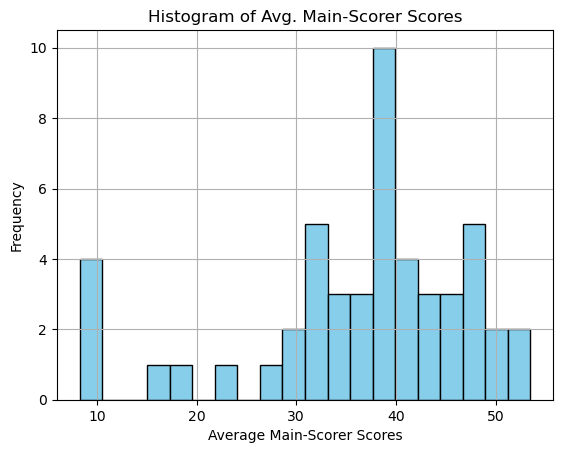

In [ ]:
df_matches['avg_main_score'].hist(bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Average Main-Scorer Scores')
plt.ylabel('Frequency')
plt.title('Histogram of Avg. Main-Scorer Scores')

# Visual Explanation

The code below highlights the parts of a selected patient record that are found most relevant to the trial inclusion criteria. It can help in quick manual validation of patient eligibility.

In [ ]:
scorer_lst = [
    medsts_bert.score, st_eng_scorer.score, st_med_scorer.score
]
colors = ['#85C1E9', '#ff6961', '#e4e7d2']

data_dict, c_dict = highlight_matches(
    trial_params['inclusion'],
    df_matches.sort_values('avg_main_score', ascending=False)['TEXT'].iloc[0],
    scorer_lst, colors
)